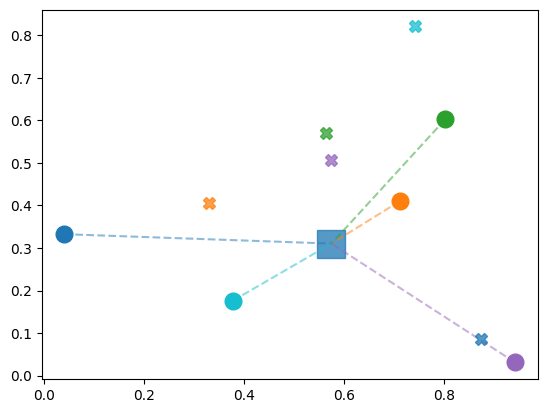

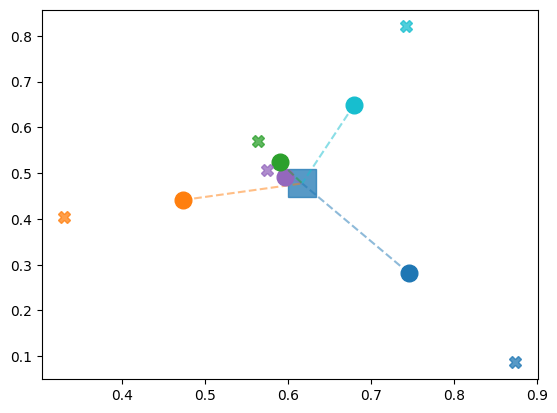

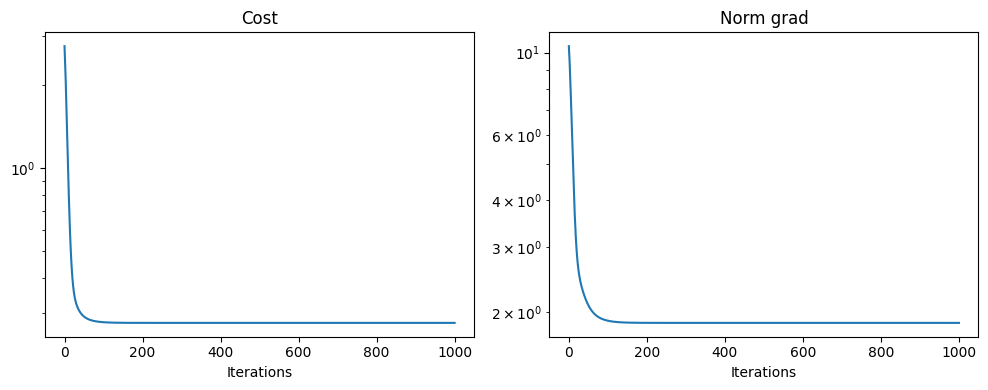

In [24]:
import numpy as np
from Function import LossFunctionTask2
from utils import create_network_of_agents
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def plot_scenario(robots_pos: np.ndarray, private_targets: np.ndarray):
    colors = [
        "tab:orange",
        "tab:purple",
        "tab:green",
        "tab:blue",
        "tab:cyan",
        "tab:red",
    ]
    barycenter = np.mean(robots_pos, axis=0)
    plt.plot(
        barycenter[0],
        barycenter[1],
        "s",
        color="tab:blue",
        label="Barycenter",
        markersize=20,
        alpha=0.75,
    )
    for i in range(len(robots_pos)):
        plt.plot(
            robots_pos[i][0],
            robots_pos[i][1],
            "o",
            color=colors[i % len(colors)],
            markersize=12,
        )

        # Draw small lines segment from robot to barycenter
        plt.plot(
            [robots_pos[i][0], barycenter[0]],
            [robots_pos[i][1], barycenter[1]],
            color=colors[i % len(colors)],
            linestyle="--",
            alpha=0.5,
        )

    for i in range(len(private_targets)):
        plt.plot(
            private_targets[i][0],
            private_targets[i][1],
            "X",
            color=colors[i % len(colors)],
            label=f"Target {i}",
            markersize=8,
            alpha=0.75,
        )


def phi(x):
    return x


def grad_phi(x):
    # return np.eye(x.shape[0])
    # return 1
    return np.ones(x.shape[0])


def gradient_tracking_algorithm(
    fn_list: list[LossFunctionTask2],
    z0: np.ndarray,
    A: np.ndarray,
    alpha: float,
    num_iters: int,
    num_agents: int,
    phi: callable = phi,
    grad_phi: callable = grad_phi,
):
    z = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    s = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    v = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))

    z[0] = z0
    s[0] = phi(z0)
    for i in range(num_agents):
        v[0] = fn_list[i].grad_sigma_z(z[0][i], s[0][i])

    for k in range(num_iters):
        for i in range(num_agents):
            neighbors = np.nonzero(A[i])[0]

            z[k + 1, i] = z[k, i] - alpha * (
                fn_list[i].grad_z(z[k, i], s[k, i]) + v[k, i] * grad_phi(z[k, i])
            )
            s[k + 1, i] = sum(A[i, j] * s[k, j] for j in neighbors) + (
                phi(z[k + 1, i]) - phi(z[k, i])
            )
            v[k + 1, i] = sum(A[i, j] * v[k, j] for j in neighbors) + (
                fn_list[i].grad_sigma_z(z[k + 1, i], s[k + 1, i])
                - fn_list[i].grad_sigma_z(z[k, i], s[k, i])
            )

    return z


NUM_ROBOTS = 5
VAR_DIMS = 2
SEED = 24

rng = np.random.default_rng(SEED)

# robot_positions = rng.random(size=(NUM_ROBOTS, VAR_DIMS))
private_targets = rng.random(size=(NUM_ROBOTS, VAR_DIMS))

gamma = 1
loss_fns = [LossFunctionTask2(private_targets[i], gamma) for i in range(NUM_ROBOTS)]

robot_initial_positions = rng.random(size=(NUM_ROBOTS, VAR_DIMS))

plot_scenario(robot_initial_positions, private_targets)
plt.show()

G, A = create_network_of_agents(
    NUM_ROBOTS,
    "doubly-stochastic",
    connected=True,
    seed=SEED,
    doubly_stochastic_num_iter=10000,
    graph_algorithm="erdos_renyi",
)

z_history = gradient_tracking_algorithm(
    fn_list=loss_fns,
    z0=robot_initial_positions.copy(),
    A=A,
    num_iters=1000,
    alpha=2e-2,
    num_agents=NUM_ROBOTS,
)


plot_scenario(z_history[-1], private_targets)
plt.show()

cost_history = [
    sum([loss_fns[i](z_i, np.mean(z)) for i, z_i in enumerate(z)]) for z in z_history
]

grad_cost_history = [
    sum(
        [
            np.linalg.norm(loss_fns[i].grad(z_i, np.mean(z)), 2)
            for i, z_i in enumerate(z)
        ]
    )
    for z in z_history
]
# print(cost_history)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Cost")
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.title("Norm grad")
plt.plot(grad_cost_history)
plt.xlabel("Iterations")
plt.yscale("log")
plt.tight_layout()
plt.show()

In [15]:
len(z_history)

1001

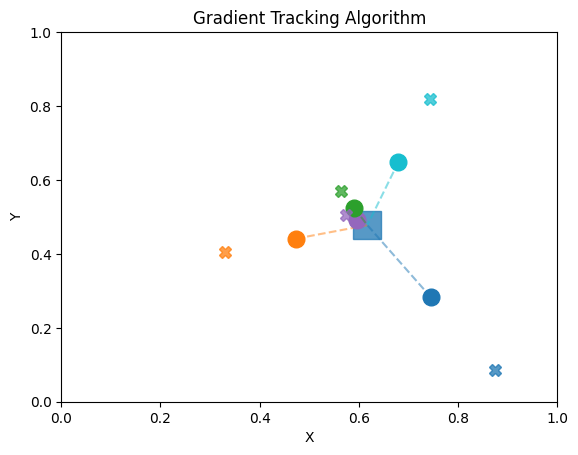

In [26]:
from IPython.display import HTML
# Create an animation, by showing the scenario at each iteration
def animate_scenario(z_history, private_targets, skip=2):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Gradient Tracking Algorithm")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    frames = range(0, 400, skip)

    def update(frame_idx):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("Gradient Tracking Algorithm")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plot_scenario(z_history[frames[frame_idx]], private_targets)
        return (ax,)

    ani = FuncAnimation(fig, update, frames=len(frames), blit=False, interval=200)

    # Fix: Display the animation
    display(HTML(ani.to_jshtml()))


    # plt.show()

animate_scenario(z_history, private_targets)

In [ ]:
), blit=True, interval=200)

    
